In [139]:
"""
These codes aim to replicate the dynamics (figure 3, pp.238) of the celebrated model 
proposed by kiyotaki and moore 1997


Reference

Kiyotaki, N., & Moore, J. (1997). Credit cycles. Journal of Political Economy, 105(2), 211-248
Kiyotaki, N., & Moore, J. (1995). Credit Cycles (No. w5083). National Bureau of Economic Research
"""

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import fsolve

class CreditCycles:
    """
    parameters
    ------
    R = 1.01 # quarterly interest rate, equals 4% annual rate
    lamda = 0.975 # quarterly depreciation rate, equals 10% annual rate
    pi = 0.1 # average interval between investments for a farmer is 2.5 years
    phi = 20 # which makes the steady state aggregate/marginal debt/asset ratio are 63% and 71%, respectively
    a = 1 # normalizing
    """
    def __init__(self, R=1.01, lamda=0.975, pi=0.1, phi=20, a=1):
        # store model parameters
        self.R, self.lamda, self.pi, self.phi, self.a = R, lamda, pi, phi, a
        
    # first, let's pin down the intercept v in the equation
    #u(K) = K - v
    #which makes the elasticity of the residual supply of land to farmers
    #equal to 10 percent in the steady state
    def ss_u(self):
        # simplifying
        R, lamda, pi, phi, a = self.R, self.lamda, self.pi, self.phi, self.a
        # using equation (25a) to derive steady-state u
        temp1 = pi * a - (1 - lamda) *(1 - R + pi * R) * phi
        temp2 = lamda * pi + (1 - lamda) * (1 - R + pi * R)
        return temp1/temp2
    
    def ss_q(self):
        R, lamda, pi, phi, a = self.R, self.lamda, self.pi, self.phi, self.a
        return self.ss_u() * R / (R - 1)
    
    def temp_K(self, v):
        R, lamda, pi, phi, a = self.R, self.lamda, self.pi, self.phi, self.a
        return self.ss_u() + v
    
    def eta(self, v):
        R, lamda, pi, phi, a = self.R, self.lamda, self.pi, self.phi, self.a
        return self.temp_K(v) / (self.temp_K(v) - v) - 10
    
    def v_star(self):
        R, lamda, pi, phi, a = self.R, self.lamda, self.pi, self.phi, self.a
        return fsolve(self.eta, 5)
    
    # now, we can compute the steady state (K, B, q) by equation (25a) -(25c)
    def ss_K(self):
        R, lamda, pi, phi, a = self.R, self.lamda, self.pi, self.phi, self.a
        return self.ss_u() + self.v_star()
    
    def ss_B(self):
        R, lamda, pi, phi, a = self.R, self.lamda, self.pi, self.phi, self.a
        return (a - phi + lamda * phi) * self.ss_K() / (R - 1)

    def steady_state(self):
        R, lamda, pi, phi, a = self.R, self.lamda, self.pi, self.phi, self.a
        return self.ss_K()[0], self.ss_B()[0], self.ss_q()
    
    # and total land stock is set to satisfy K*/K^bar = 2/3
    def K_bar(self):
        R, lamda, pi, phi, a = self.R, self.lamda, self.pi, self.phi, self.a
        return 1.5 * self.ss_K()

    # and the updating map from (K_t-1, B_t-1, q_t) to (K_t, B_t, q_t+1) by equation (12), (23), and (24)
    def u(self, K):
        R, lamda, pi, phi, a = self.R, self.lamda, self.pi, self.phi, self.a
        v =self.v_star()
        return K - v
    
    def new_q(self, K, B, q):
        R, lamda, pi, phi, a = self.R, self.lamda, self.pi, self.phi, self.a
        return R * (q - self.u(K))
    
    def new_K(self, K, B, q):
        R, lamda, pi, phi, a = self.R, self.lamda, self.pi, self.phi, self.a
        temp1 = (1 - pi) * lamda * K
        temp2 = pi / (phi + q - self.new_q(K, B, q)/R)
        temp3 = (a + q +lamda * phi) * K - R * B
        return temp1 + temp2 * temp3
    
    def new_B(self, K, B, q):
        R, lamda, pi, phi, a = self.R, self.lamda, self.pi, self.phi, self.a
        return R * B + q * (self.new_K(K, B, q) - K) + phi * (self.new_K(K, B, q) - lamda * K) - a * K      
    
    def update(self, values):
        R, lamda, pi, phi, a = self.R, self.lamda, self.pi, self.phi, self.a
        (K, B, q) = values
        qq = self.new_q(K, B, q)
        KK = self.new_K(K, B, q)
        BB = self.new_B(K, B, q)
        return KK[0], BB[0], qq[0]
    
    # given initial values, we can simulate the dynamic path by using the update function iterately
    def simulate(self, init, N):
        """
        parameters:
        ------
        init: initial values of K, B, and q
        N: periods to be simulated
        
        """
        R, lamda, pi, phi, a = self.R, self.lamda, self.pi, self.phi, self.a
        K = np.empty(N)
        B = np.empty(N)
        q = np.empty(N)
        
        (K[0], B[0], q[0]) = init
        for n in range(1, N):
            Ktp, Btp, qtp = self.update((K[n-1], B[n-1], q[n-1]))
            K[n] = Ktp
            B[n] = Btp
            q[n] = qtp
        
        return K, B, q
    
    #finally, we compute the contemporary impact of an unanticipated shock in productivity by equation (29)
    def q_hat(self, delta):
        R, lamda, pi, phi, a = self.R, self.lamda, self.pi, self.phi, self.a
        temp1 = lamda * pi + (1 - lamda) * (1 - R + pi * R)
        temp2 = 1 - lamda + lamda * pi
        temp3 = a / (a +lamda * phi)
        return temp1/ temp2 *temp3 * delta * 10

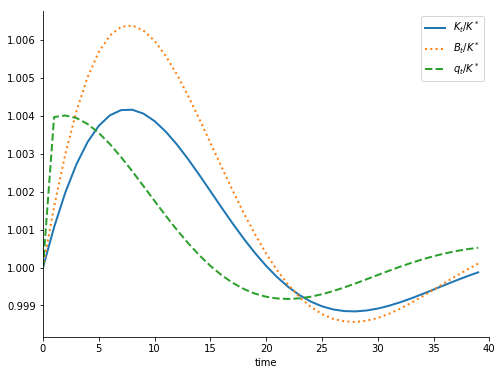

In [188]:
CC = CreditCycles(R=1.01, lamda=0.975, pi=0.1, phi=20, a=1)
K_d = CC.simulate((CC.steady_state()[0], CC.steady_state()[1], 
                   CC.steady_state()[2]*(1+CC.q_hat(0.01))), 40)[0]/CC.steady_state()[0]
B_d = CC.simulate((CC.steady_state()[0], CC.steady_state()[1], 
                   CC.steady_state()[2]*(1+CC.q_hat(0.01))), 40)[1]/CC.steady_state()[1]
q_d = CC.simulate((CC.steady_state()[0], CC.steady_state()[1], 
                   CC.steady_state()[2]*(1+CC.q_hat(0.01))), 40)[2]/CC.steady_state()[2]
#note that the updating map is from (K_t-1, B_t-1, q_t) to (K_t, B_t, q_t+1), so we have to
#move the sequence of q_t forward by 1 period
real_q_d = np.append([1], q_d[0: 39]) 

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(K_d, label=r"$K_t/K^*$", lw=2)
ax.plot(B_d, label=r"$B_t/K^*$", linestyle='dotted', lw=2)
ax.plot(real_q_d, label=r"$q_t/K^*$", linestyle='dashed', lw=2)
ax.legend(loc='upper right')
ax.set_xlim(0, 40)
ax.set_xlabel("time")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()